In [1]:
import pandas as pd
import numpy as np
import itertools
import os
from pathlib import Path

# File paths
os.chdir(Path().absolute().parent)

from BackBone.preprocessing import loader
from BackBone.tools import Input_tools
from BackBone import config as cfg

# Plot imports
import seaborn as sns
import matplotlib.pyplot as plt
import math
sns.set_style("darkgrid")

### World map packs
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
from geopy.geocoders import Nominatim
import folium
from folium.plugins import MarkerCluster

In [2]:
## Providing input filename and year
filename = "Input_data_file.xlsx"
loader.configure_paths(filename)

In [3]:
data = loader.load_input(calc_edges=False)

Loading input data from pickle.
Loading edges from pickle: c:\Users\JHIV\OneDrive - Novo Nordisk\Thesis\Model\Data\Input\Input_data_file\Input_data_file_edges.pickle


# Descriptive statistics of input data 

### Data foundation summary 

Firstly, we investigate the models data fooundation, to get insights into the scale of the problem 

In [4]:
# Number of products
print("Total number of products:", len(data['Product_variant']['Product_id'].unique()))

# Number of customers
print("Total number of Customers:", len(data['Product_variant']['Customer_Id'].unique()))

# Number of lines
print("Total number of packaging lines:", len(data['Line_Capacity']['Line_Id'].unique()))

# # Total yearly line capacity
# print("Total number of packaging lines:", len(data['Line_Capacity']['Line_Id'].unique()))

# Number of sites
print("Total number of sites:", len(data['Line_Capacity']['Site_Id'].unique()))

# Total Demand the next 3 months
print("Total Demand for the remaining of 2022 (units):", f"{sum(data['GSF'][data['GSF']['Fiscal year']==2022]['Volume_U3']):,}")

# Avg distribution leadtime to customers
print("Average distribution time to customers (days):", data['LeadTimes']['Avg_leadtime'].mean())


Total number of products: 8
Total number of Customers: 116
Total number of packaging lines: 1
Total number of sites: 1
Total Demand for the remaining of 2022 (units): 11,640,578
Average distribution time to customers (days): 9.234567901234568


#### Customers countryes

To get an overview of the size of the network, the customer countries are investivated and plotted on a global map

In [5]:
#countries
print('Regions:   ', data['Customer_Countries']['SalesRegionText'].unique())
print(' ')
print('Customer countries:    ',data['Customer_Countries']['CountryText'].unique())

Regions:    ['Region NWE' 'Region Germany' 'Region SEEMEA' 'North America'
 'Region LATAM' 'Region APAC' 'Region China']
 
Customer countries:     ['France' 'Netherlands' 'Germany' 'Italy' 'Ireland' 'Denmark' 'Greece'
 'Portugal' 'Spain' 'Belgium' 'Luxembourg' 'Iceland' 'Norway' 'Sweden'
 'Finland' 'Austria' 'Switzerland' 'Malta' 'Turkey' 'Estonia' 'Latvia'
 'Lithuania' 'Poland' 'Czech Republic' 'Hungary' 'Romania' 'Bulgaria'
 'Albania' 'Ukraine' 'Belarus' 'Russia' 'Georgia' 'Azerbaijan'
 'Kazakhstan' 'Turkmenistan' 'Uzbekistan' 'Slovenia' 'Croatia'
 'Bosnia-Herzegovina' 'North Macedonia' 'Montenegro' 'Serbia' 'Morocco'
 'Algeria' 'Tunisia' 'Egypt' "Cote d'Ivoire" 'Ghana' 'Nigeria' 'Gabon'
 'Kenya' 'Reunion' 'Mauritius' 'Zimbabwe' 'South Africa' 'United States'
 'Canada' 'Guatemala' 'Honduras' 'El Salvador' 'Nicaragua' 'Costa Rica'
 'Panama' 'Cuba' 'Bahamas' 'Dominican Republic' 'Guadeloupe' 'Martinique'
 'Barbados' 'Trinidad & Tobago' 'Aruba' 'Sint Maarten' 'Curacao'
 'Colombia' 'Fren

In [39]:
Input_tools.map()

Distribution of sales by customer country

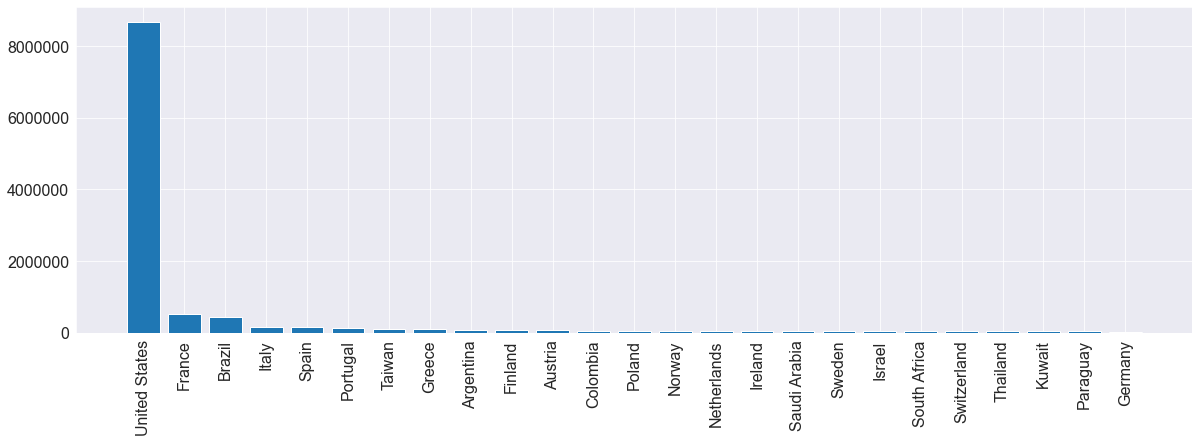

In [38]:
df_demand = data['GSF'].merge(data['Customer_Countries'], how = 'left', left_on = 'Country_ID', right_on = 'Customer_Id')
customer_demand = pd.DataFrame(df_demand[df_demand['Fiscal year']==2022].groupby('CountryText').sum()['Volume_U3'].reset_index())

plt.figure(figsize=(20, 6))
plt.xticks(rotation=90,fontsize=16)
plt.yticks(fontsize=16)
plt.ticklabel_format(style='plain')
plt.bar(customer_demand.sort_values('Volume_U3',ascending=False).head(25)['CountryText'],\
    customer_demand.sort_values('Volume_U3',ascending=False).head(25)['Volume_U3'])

plt.show()

The volume distribution is illustrated to see which regions are have the greatest demand, ond which products are selling the most

In [19]:
df = data['Product_variant'][['Customer_Id', 'Product_id']]
df = df.merge(data['GSF'][data['GSF']['Fiscal year']==2022].groupby(['Country_ID', 'Product_id']).sum()['Volume_U3'], \
    how = 'left', left_on = ['Customer_Id', 'Product_id'], right_on = ['Country_ID', 'Product_id'])
df = df.merge(pd.DataFrame(data['Customer_Countries'][['Customer_Id', 'SalesRegionText']].values.tolist(), columns = ['Country_Id' ,'Region']), \
     how = 'left', left_on = 'Customer_Id', right_on = 'Country_Id')

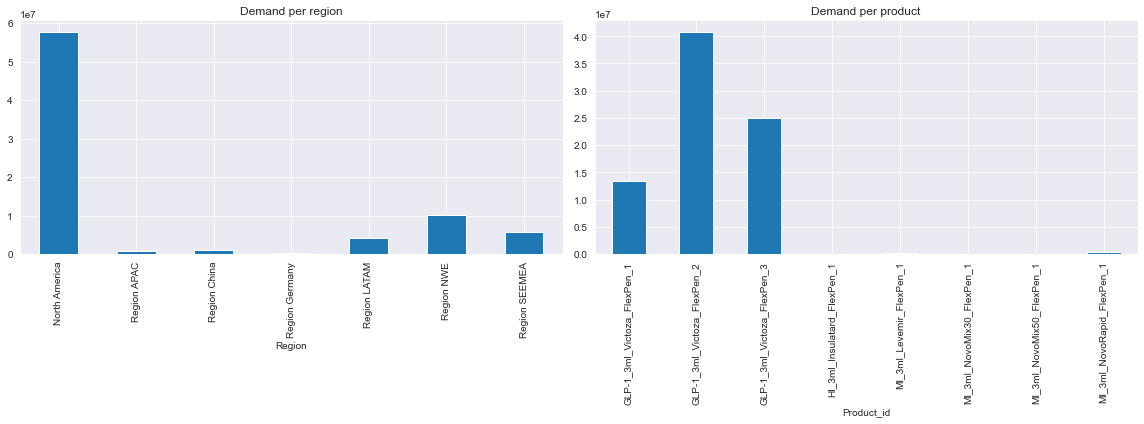

In [23]:
fig, axes = plt.subplots(1,2, figsize=(16,6))

df.groupby('Region').sum()['Volume_U3'].plot.bar(title = 'Demand per region', ax=axes[0])
df.groupby('Product_id').sum()['Volume_U3'].plot.bar(title = 'Demand per product', ax=axes[1])

fig.tight_layout()

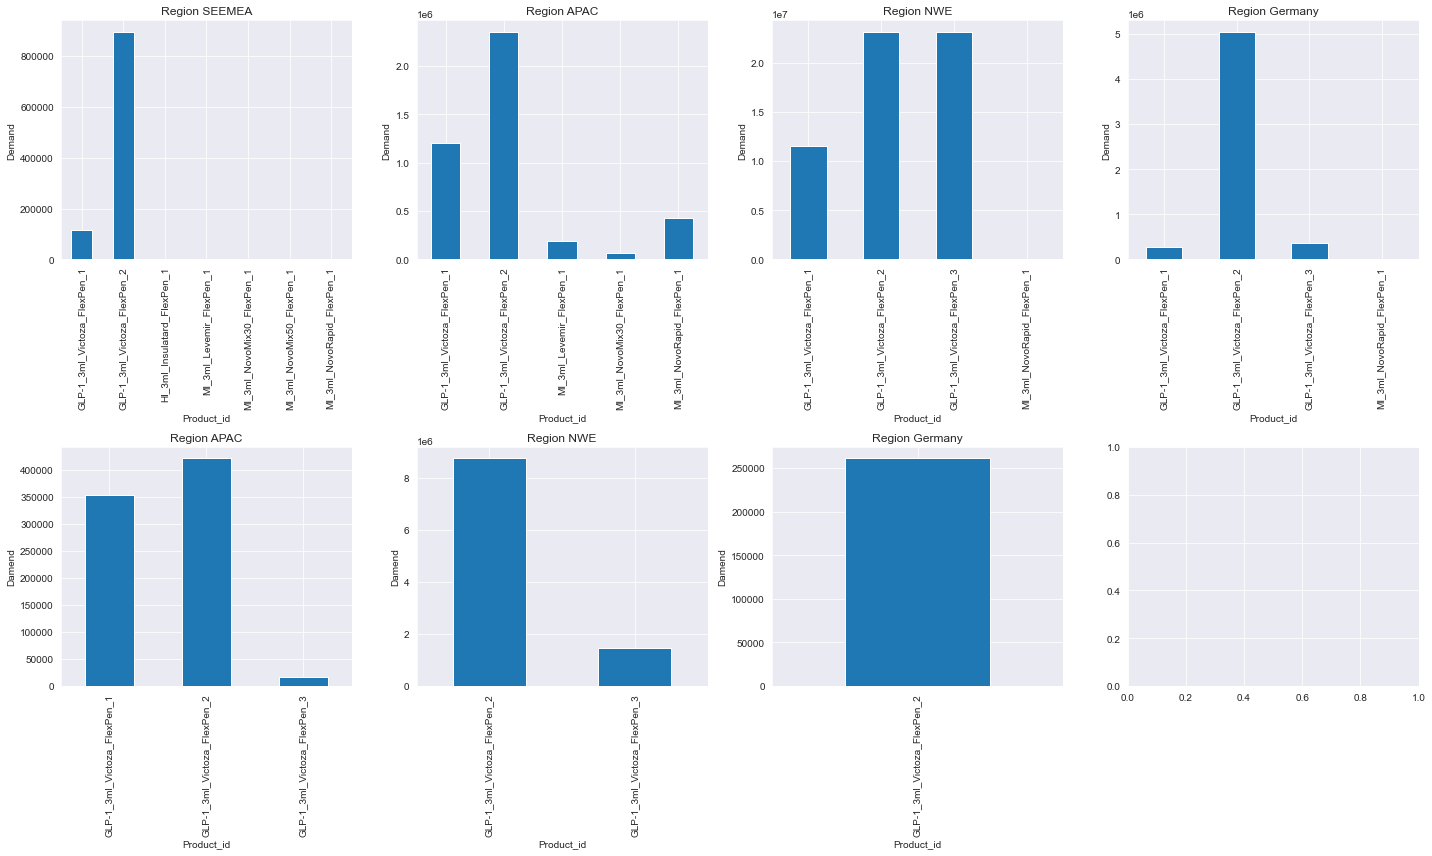

In [10]:
fig, axes = plt.subplots(2,4, figsize=(20,12))
regions = df['Region'].unique()

for j in range(2):
    if j <1:
        for i in range(4):
            df[df['Region']==regions[i+j]].groupby('Product_id').sum()['Volume_U3'].plot.bar(ylabel = 'Demand', title = regions[i+j+3], ax = axes[j,i])
    else:        
        for i in range(3):
            df[df['Region']==regions[i+j+3]].groupby('Product_id').sum()['Volume_U3'].plot.bar(ylabel = 'Damend', title = regions[i+j+3], ax = axes[j,i])
            
fig.tight_layout()

### 4pl lead times

As the customers are spread over many different regions, the distribution lead time from the packaging site in Kalundborg to different regions are found

In [11]:
pl_df = pd.read_csv(r'C:\Users\JHIV\OneDrive - Novo Nordisk\Thesis\Model\Data\Data_Input\leadtime_all.csv', sep=',')

In [12]:
pl_df.head(2)

,Location,Customer_Id,CountryText,shipment_mot,Order Actual Delivery Date/Time,Order Local Planned Delivery Date/Time,Order Actual Pickup Date/Time,LeadTime
0,2022,647,United Arab Emirates,AIR,2022-05-29 23:55:00,2022-05-29 23:55:00,2022-05-27 10:00:00,2
1,2022,647,United Arab Emirates,AIR,2022-05-29 23:55:00,2022-05-29 23:55:00,2022-05-27 10:00:00,2


In [13]:
country_info = pd.read_csv(r'C:\Users\JHIV\OneDrive - Novo Nordisk\Thesis\Model\Data\Data_Input\Country_specifics.csv', sep=',')

In [14]:
df =pl_df.merge(country_info, how='left', on = 'Customer_Id')
df = df[['Customer_Id','Order Actual Delivery Date/Time ','shipment_mot','LeadTime','CountryGroup','SalesRegionText']]
regions = df['SalesRegionText'].unique()

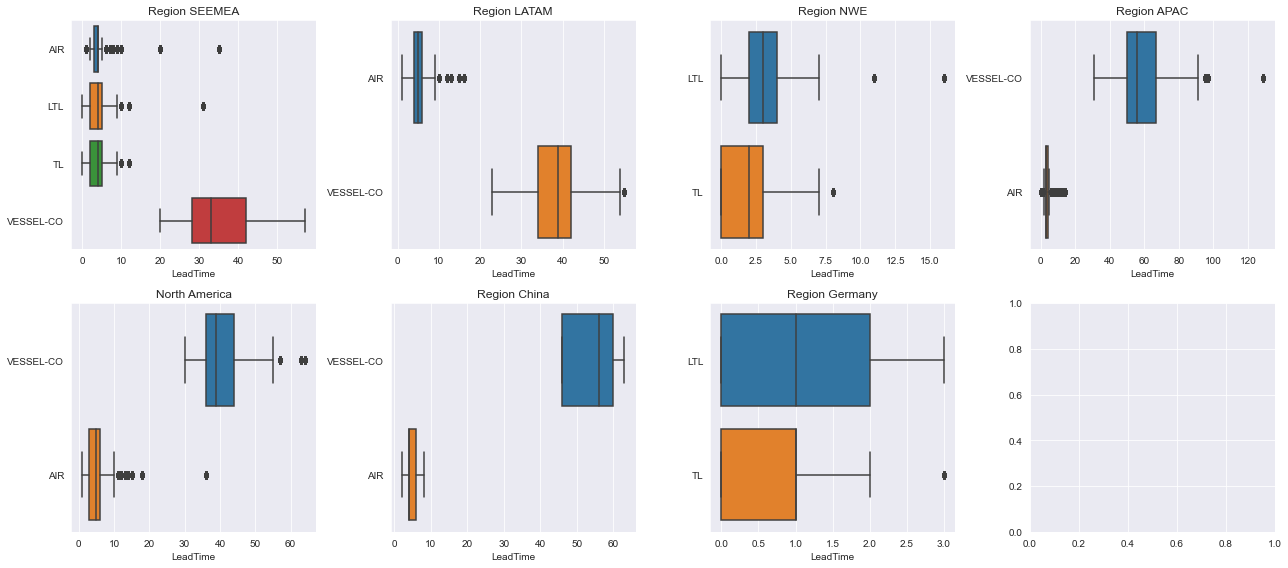

In [15]:
fig, axes = plt.subplots(2,4, figsize=(18,8))

for j in range(2):
    if j <1:
        for i in range(4):
            sns.boxplot(data=df[(df.SalesRegionText == regions[i+j])], x='LeadTime', y='shipment_mot', ax = axes[j,i])
            axes[j,i].set_title(regions[i+j])
            axes[j,i].set(ylabel=None)
    else:        
        for i in range(3):
            sns.boxplot(data=df[(df.SalesRegionText == regions[i+j+3])], x='LeadTime', y='shipment_mot', ax = axes[j,i])
            axes[j,i].set_title(regions[i+j+3])
            axes[j,i].set(ylabel=None)

fig.tight_layout()